# Studying the correlations between variables

## Load and process data

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

# Load BMRS dataset
df_bmrs = pd.read_csv(
    os.path.join(data_dir, "bmrs_data.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

# Sort by date and period
df_bmrs = df_bmrs.sort_values(["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"])

print("BMRS dataset:\n")
print(df_bmrs.info())

# Load gas prices
df_gas = pd.read_csv(
    os.path.join(data_dir, "gas_prices.csv"),
    parse_dates=["SETTLEMENT_DATE"]
)

# Sort by date
df_gas = df_gas.sort_values(["SETTLEMENT_DATE"])

print("Gas dataset:\n")
print(df_gas.info())

# Load weather dataset
df_weather = pd.read_csv(
    os.path.join(data_dir, "weather_data.csv"),
    parse_dates=["ob_time"],
)

# Sort by timestamp
df_weather = df_weather.sort_values(["ob_time"])

print("Weather dataset:\n")
print(df_weather.info())

BMRS dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68208 entries, 0 to 68207
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SETTLEMENT_DATE    68208 non-null  datetime64[ns]
 1   SETTLEMENT_PERIOD  68208 non-null  int64         
 2   BIOMASS            68208 non-null  float64       
 3   GAS                68208 non-null  float64       
 4   COAL               68208 non-null  float64       
 5   OIL                68208 non-null  float64       
 6   NUCLEAR            68208 non-null  float64       
 7   SOLAR              68208 non-null  float64       
 8   WIND               68208 non-null  float64       
 9   OTHER              68208 non-null  float64       
 10  INTER              68208 non-null  float64       
 11  INDO               68208 non-null  float64       
 12  ITSO               68208 non-null  float64       
 13  ELECTRICITY_PRICE  68208 non-null  float64    

In [2]:
# Average over locations in weather dataset
df = df_weather.reset_index()
df_weather = df.groupby("ob_time").mean(numeric_only=True).reset_index()

In [3]:
# Construct time stamps from settlement dates and periods
from utilities import create_timestamps

df_bmrs["datetime"] = create_timestamps(
    df_bmrs, "SETTLEMENT_DATE", "SETTLEMENT_PERIOD", tz=None
)

Merge dataframes:

In [4]:
generation_types = [
    "NUCLEAR", "GAS", "WIND", "INTER", "BIOMASS",
    "SOLAR", "COAL", "OIL", "OTHER"
]

# Compute total generation
gen_by_type = df_bmrs[generation_types]
df_bmrs["TOTAL_GENERATION"] = gen_by_type.sum(axis=1)

# Remove timezone from weather data
df_weather.rename(columns={"ob_time": "datetime"}, inplace=True)

# Merge datasets
df_merged = df_bmrs.merge(df_weather, on="datetime", how="inner")
df_merged = df_merged.merge(df_gas, on="SETTLEMENT_DATE", how="inner")

## Correlation plots

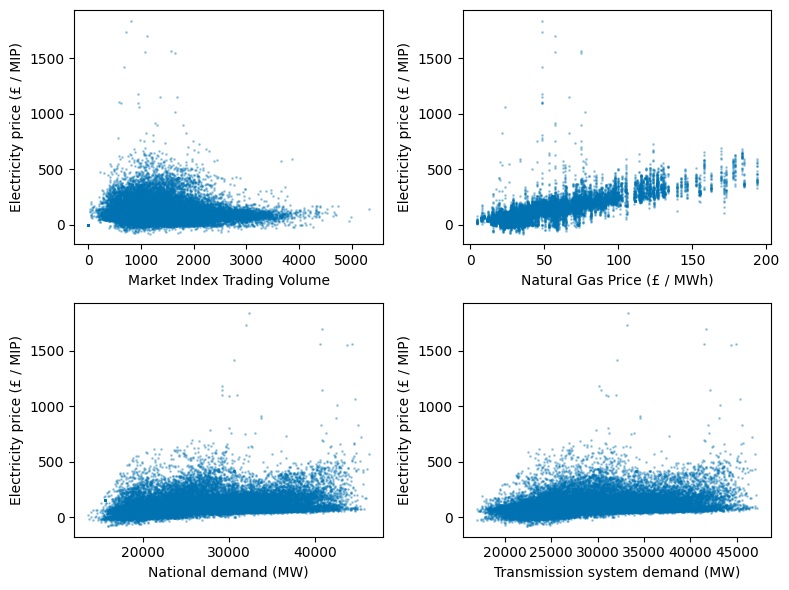

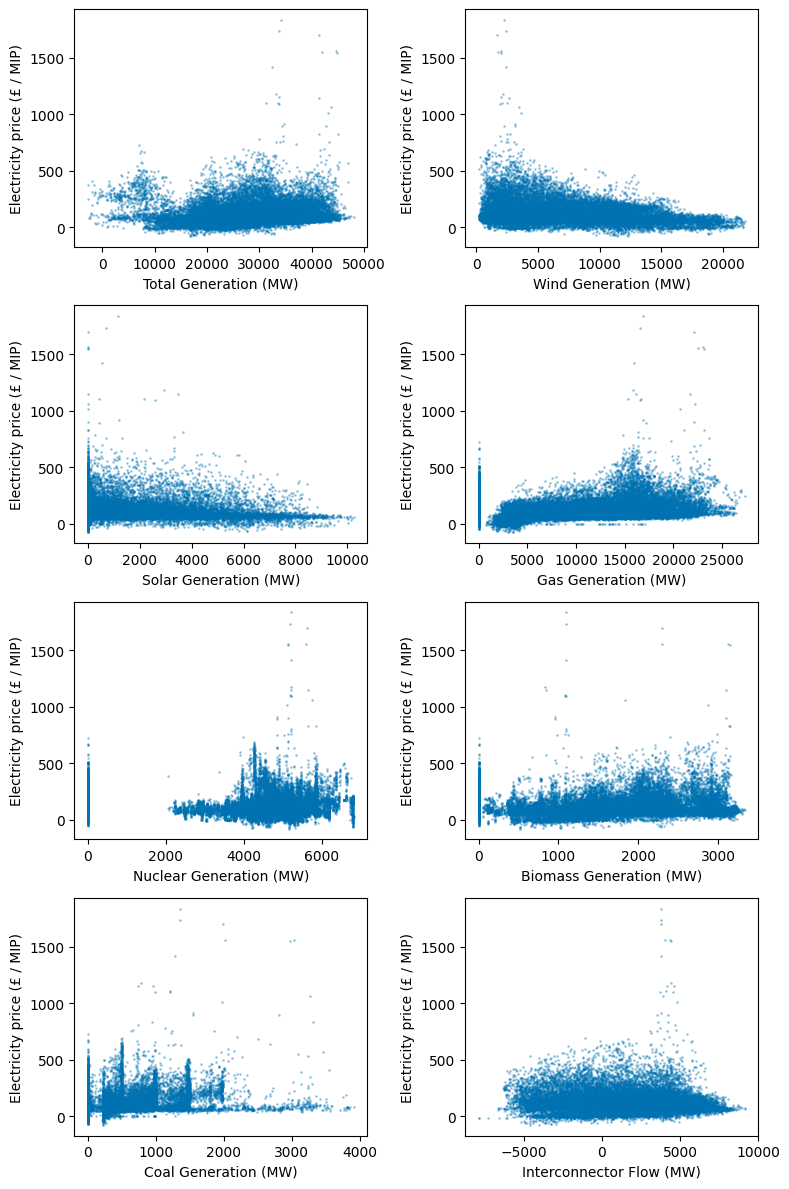

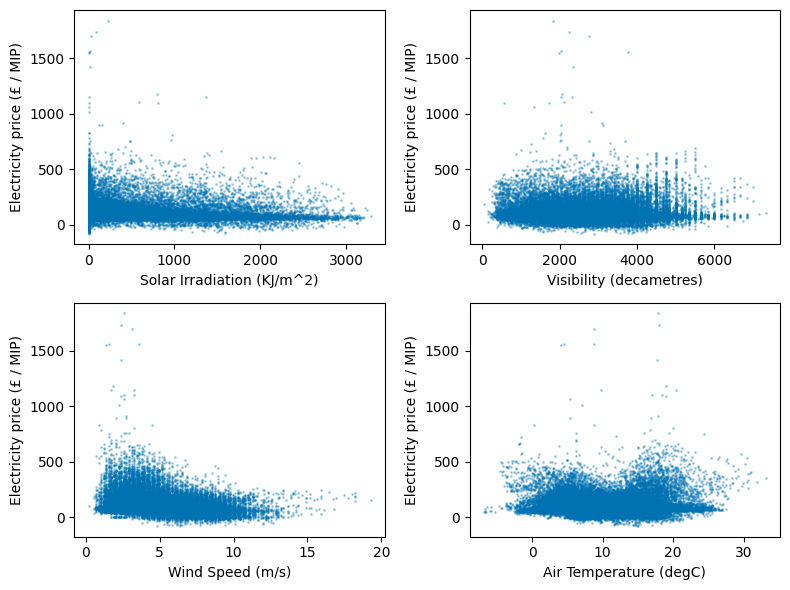

In [5]:
market_variables = {
    "TRADING_VOLUME": "Market Index Trading Volume",
    "NATURAL_GAS_PRICE": "Natural Gas Price (£ / MWh)",
    "INDO": "National demand (MW)",
    "ITSO": "Transmission system demand (MW)",
}

generation_variables = {
    "TOTAL_GENERATION": "Total Generation (MW)",
    "WIND": "Wind Generation (MW)",
    "SOLAR": "Solar Generation (MW)",
    "GAS": "Gas Generation (MW)",
    "NUCLEAR": "Nuclear Generation (MW)",
    "BIOMASS": "Biomass Generation (MW)",
    "COAL": "Coal Generation (MW)",
    "INTER": "Interconnector Flow (MW)",
}

weather_variables = {
    "glbl_irad_amt": "Solar Irradiation (KJ/m^2)",
    "visibility": "Visibility (decametres)",
    "wind_speed": "Wind Speed (m/s)",
    "air_temperature": "Air Temperature (degC)",
}

variables = market_variables | generation_variables | weather_variables

variables = {
    # market variables
    "TRADING_VOLUME": "Market Index Trading Volume",
    "NATURAL_GAS_PRICE": "Natural Gas Price",
    "INDO": "National demand",
    "ITSO": "Transmission system demand",
    # generation variables
    "TOTAL_GENERATION": "Total Generation",
    "WIND": "Wind Generation",
    "SOLAR": "Solar Generation",
    "GAS": "Gas Generation",
    "NUCLEAR": "Nuclear Generation",
    "BIOMASS": "Biomass Generation",
    "COAL": "Coal Generation",
    "INTER": "Interconnector Flow",
    # weather variables
    "glbl_irad_amt": "Solar Irradiation",
    "visibility": "Visibility",
    "wind_speed": "Wind Speed",
    "air_temperature": "Air Temperature",
}

target = "ELECTRICITY_PRICE"
target_string = "Electricity price (£ / MIP)"

fig, axes = plt.subplots(2, 2, layout="tight", figsize=(8, 6))
for ax, (var, label) in zip(axes.flat, market_variables.items()):
    ax.scatter(df_merged[var], df_merged[target], alpha=0.3, s=1)
    ax.set_xlabel(label)
    ax.set_ylabel(target_string, fontsize=10)
plt.show()

fig, axes = plt.subplots(4, 2, layout="tight", figsize=(8, 12))
for ax, (var, label) in zip(axes.flat, generation_variables.items()):
    ax.scatter(df_merged[var], df_merged[target], alpha=0.3, s=1)
    ax.set_xlabel(label)
    ax.set_ylabel(target_string, fontsize=10)
plt.show()

fig, axes = plt.subplots(2, 2, layout="tight", figsize=(8, 6))
for ax, (var, label) in zip(axes.flat, weather_variables.items()):
    ax.scatter(df_merged[var], df_merged[target], alpha=0.3, s=1)
    ax.set_xlabel(label)
    ax.set_ylabel(target_string, fontsize=10)
plt.show()

## Linear correlation coefficients

In [6]:
# Compute correlation coefficients

import scipy.stats

correlation_results = []
for var, label in variables.items():
    valid_data = df_merged[[var, target]].dropna()  # drop NaNs
    pearson_r, pearson_p = scipy.stats.pearsonr(
        valid_data[var], valid_data[target]
    )
    spearman_r, spearman_p = scipy.stats.spearmanr(
        valid_data[var], valid_data[target]
    )

    correlation_results.append(
        {
            "Variable": label,
            "Pearson": pearson_r,
            "Pearson p-value": pearson_p,
            "Spearman": spearman_r,
            "Spearman p-value": spearman_p,
        }
    )

corr_df = pd.DataFrame(correlation_results)
corr_df = corr_df.sort_values("Pearson", key=abs, ascending=False)

print("Correlations with electricity price:")
print(corr_df.to_string(index=False))

Correlations with electricity price:
                   Variable   Pearson  Pearson p-value  Spearman  Spearman p-value
          Natural Gas Price  0.798779     0.000000e+00  0.784041      0.000000e+00
             Gas Generation  0.336610     0.000000e+00  0.424506      0.000000e+00
 Transmission system demand  0.328004     0.000000e+00  0.374543      0.000000e+00
            National demand  0.298223     0.000000e+00  0.335908      0.000000e+00
            Coal Generation  0.272225     0.000000e+00  0.268996      0.000000e+00
                 Wind Speed -0.195565    3.728776e-291 -0.202435      0.000000e+00
        Interconnector Flow -0.187638    8.734908e-268 -0.186029     3.599756e-263
            Wind Generation -0.160915    1.428284e-196 -0.110517      3.874627e-93
Market Index Trading Volume -0.129213    6.969187e-127 -0.127192     5.637254e-123
           Total Generation  0.114565    5.465571e-100  0.192767     8.651019e-283
           Solar Generation -0.068536     8.553338

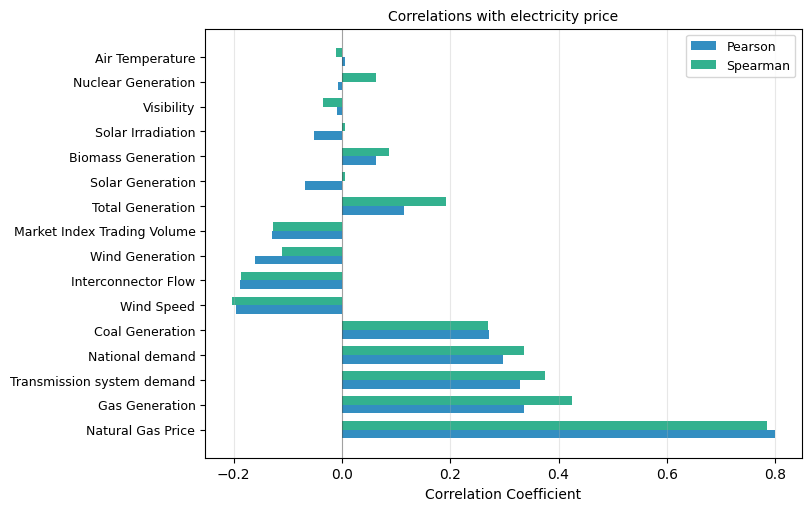

In [7]:
# Plot correlation coefficients
fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")
x = np.arange(len(corr_df))
width = 0.35
bars1 = ax.barh(
    x - width / 2, corr_df["Pearson"], width, label="Pearson", alpha=0.8
)
bars2 = ax.barh(
    x + width / 2, corr_df["Spearman"], width, label="Spearman", alpha=0.8
)
ax.set_yticks(x)
ax.set_yticklabels(corr_df["Variable"], fontsize=9)
ax.set_xlabel("Correlation Coefficient", fontsize=10)
ax.set_title("Correlations with electricity price", fontsize=10)
ax.legend(fontsize=9)
ax.axvline(x=0, color="black", linewidth=0.8, linestyle="-", alpha=0.3)
ax.grid(axis="x", alpha=0.3)

plt.show()